In [39]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [40]:
nielsen15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
nielsen16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
nielsen15['year'] = 2015
nielsen16['year'] = 2016
nielsen = pd.concat((nielsen15, nielsen16))

In [41]:
category = 'FRESH PRODUCE'
nielsen = nielsen[nielsen.product_group_descr == category]

In [42]:
density_path = r"C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\Average_Household_Size_and_Population_Density_-_County.csv"
density = pd.read_csv(density_path)
density = density[["GEOID", "B01001_calc_PopDensity"]]

In [45]:
nielsen_d = pd.merge(nielsen, density,  how='inner', left_on='guessed_store_county_fips', right_on='GEOID')
nielsen_d = nielsen_d.rename(columns={"B01001_calc_PopDensity": "Population density (people/km^2)"})

In [66]:
## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes stil remain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]

# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]
#movements['year'] = movements.Opening_date.dt.year
#movements['month'] = movements.Opening_date.dt.month

# The control group is composed by all states where nothing (no entry nor exit) happened.
control = nielsen_d[~np.isin(nielsen_d.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatment = nielsen_d[np.isin(nielsen_d.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
control['interaction'] = False
treatment['treat'] = True
treatment['interaction'] = (treatment.purchase_month > treatment.Opening_date.dt.month) & (treatment.purchase_year >= treatment.Opening_date.dt.year)
treatment_d = treatment[["GEOID","Population density (people/km^2)"]]
density_per_county_t = treatment_d.groupby("GEOID").agg(["mean"])

Size of the control group: 2334.
Size of the treatment group: 89.


In [67]:
#criterium for control group : values in same range as for treatment
min_d = density_per_county_t.min()[("Population density (people/km^2)",'mean')]
max_d = density_per_county_t.max()[("Population density (people/km^2)",'mean')]
print(min_d, max_d)
print(control.shape[0])
print(control.describe())
control_m = control[(control["Population density (people/km^2)"]>=min_d)&(control["Population density (people/km^2)"]<=max_d)]
print(control_m.shape[0], control_m.shape[0]/control.shape[0])

3.69147125917798 4322.95256868476
79763
       guessed_store_county_fips  purchase_year  purchase_month     upc_price  \
count               79763.000000   79763.000000    79763.000000  79763.000000   
mean                30533.422351    2015.500558        6.487068      2.209814   
std                 15004.978888       0.500003        3.447957      0.627317   
min                  1001.000000    2015.000000        1.000000      0.000000   
25%                 18177.000000    2015.000000        3.000000      1.873333   
50%                 29131.000000    2016.000000        6.000000      2.158182   
75%                 42129.000000    2016.000000        9.000000      2.475448   
max                 56045.000000    2016.000000       12.000000     12.990000   

       upc_price_std     nb_of_obs          year         GEOID  \
count   76597.000000  79763.000000  79763.000000  79763.000000   
mean        1.342467     92.360430   2015.500558  30533.422351   
std         0.525570    284.9649

In [48]:
first_quartile = density_per_county_t.quantile(q=0.25)[("Population density (people/km^2)",'mean')]
third_quartile = density_per_county_t.quantile(q=0.75)[("Population density (people/km^2)",'mean')]
control_m2 = control[(control["Population density (people/km^2)"]>=first_quartile)&(control["Population density (people/km^2)"]<=third_quartile)]
print(control_m2.shape[0], control_m2.shape[0]/control.shape[0])

23296 0.2920652432832266


In [68]:
control_m = control_m[["is_walmart","store_state","guessed_store_county","guessed_store_county_fips","purchase_year","purchase_month","product_group_descr","upc_price","upc_price_std","nb_of_obs","year","treat","interaction","Population density (people/km^2)"]]

In [69]:
control_m2 = control_m2[["is_walmart","store_state","guessed_store_county","guessed_store_county_fips","purchase_year","purchase_month","product_group_descr","upc_price","upc_price_std","nb_of_obs","year","treat","interaction","Population density (people/km^2)"]]

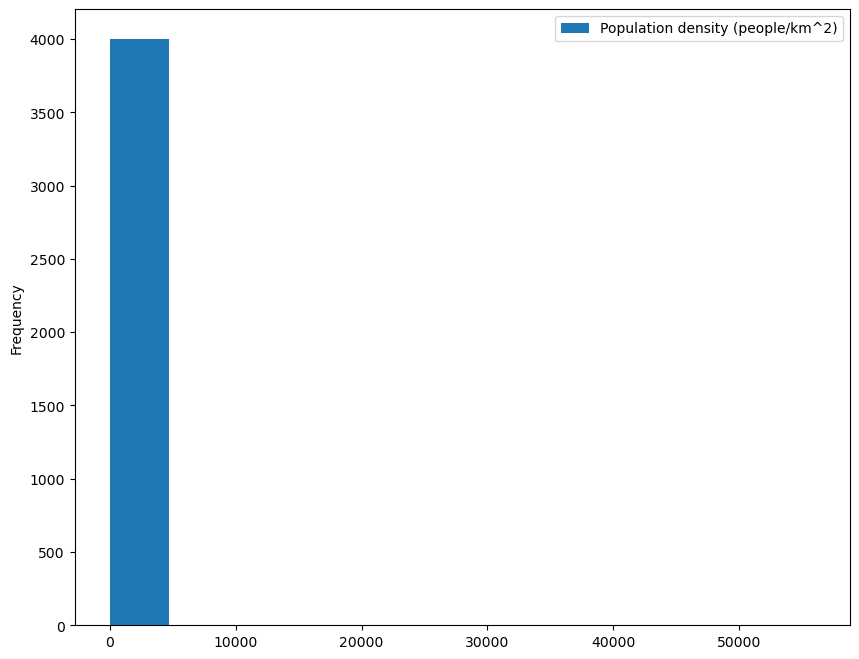

In [70]:
ax = treatment_d.plot.hist(column=["Population density (people/km^2)"], bins=12, figsize=(10, 8))

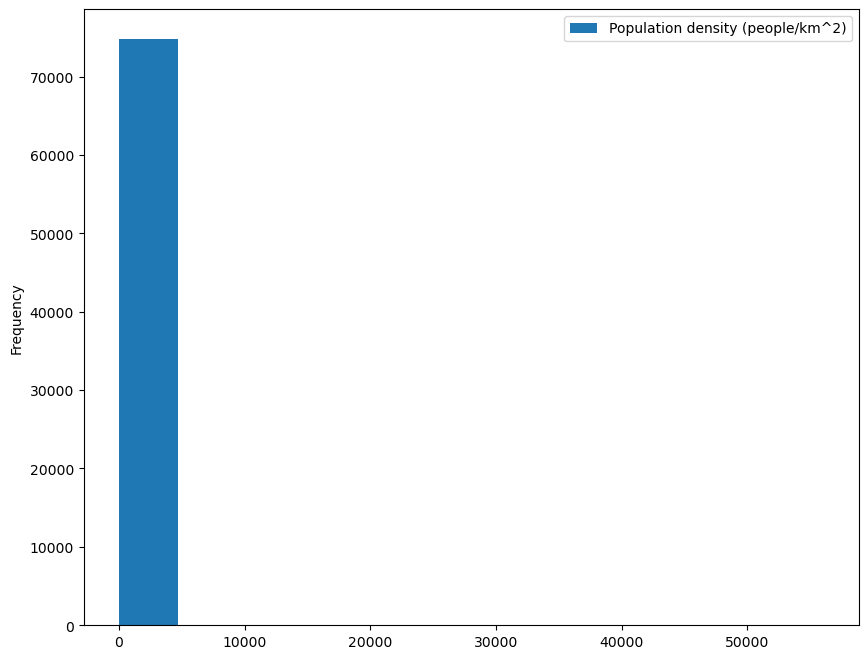

In [71]:
ax2 = control_m.plot.hist(column=["Population density (people/km^2)"], bins=12, figsize=(10, 8))

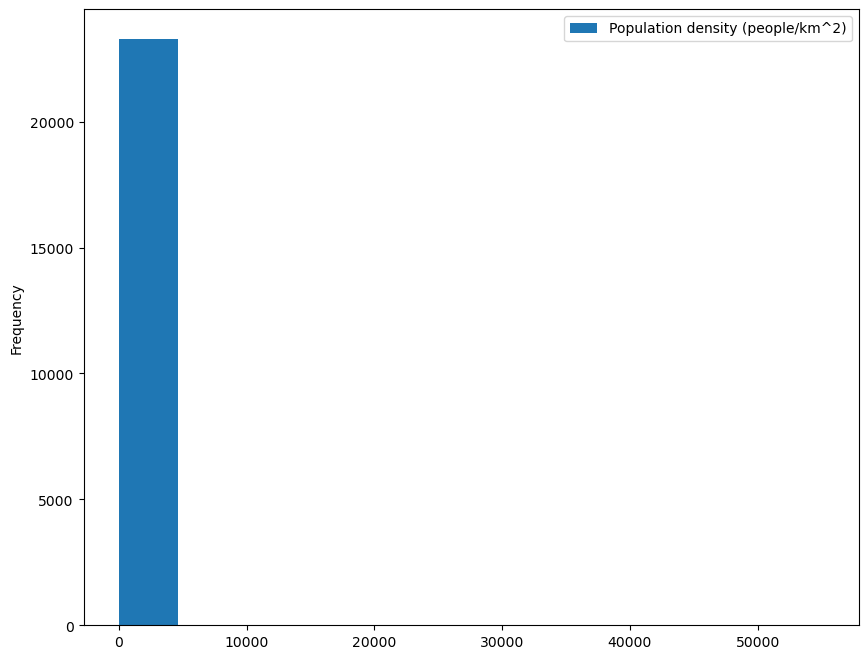

In [72]:
ax3 = control_m2.plot.hist(column=["Population density (people/km^2)"], bins=12, figsize=(10, 8))

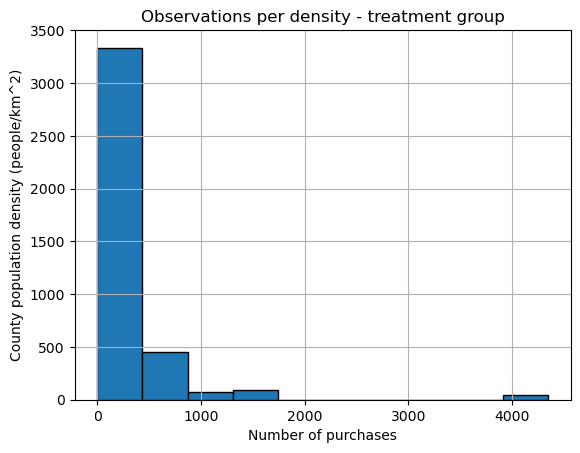

In [86]:
plt.hist(treatment_d["Population density (people/km^2)"], edgecolor='black', range=[0, 4350])
plt.xlabel('Number of purchases')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density - treatment group')
plt.grid(True)
plt.savefig("../../results_summary/density_treat_hist.png")

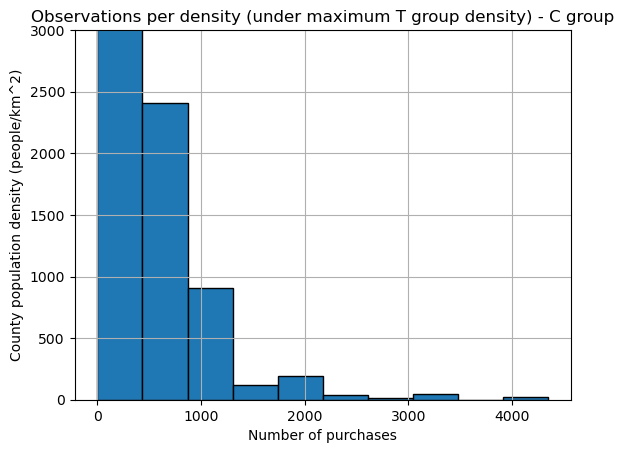

In [87]:
plt.hist(control_m["Population density (people/km^2)"], edgecolor='black', range=[0, 4350])
plt.xlabel('Number of purchases')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - C group')
plt.ylim(0, 3000)
plt.grid(True)
plt.savefig("../../results_summary/density_control_hist_0.png")

(array([23296.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([   0.,  435.,  870., 1305., 1740., 2175., 2610., 3045., 3480.,
        3915., 4350.]),
 <BarContainer object of 10 artists>)

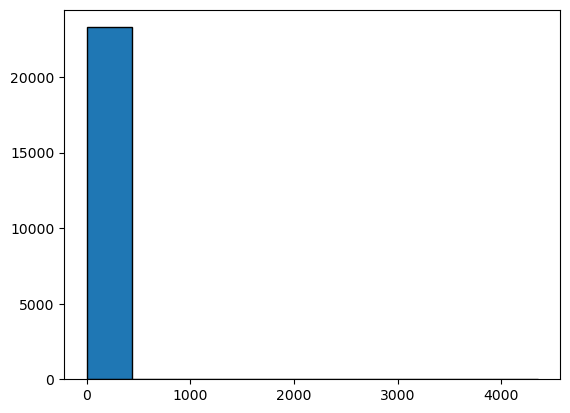

In [19]:
plt.hist(control_m2["Population density (people/km^2)"], edgecolor='black', range=[0, 4350])

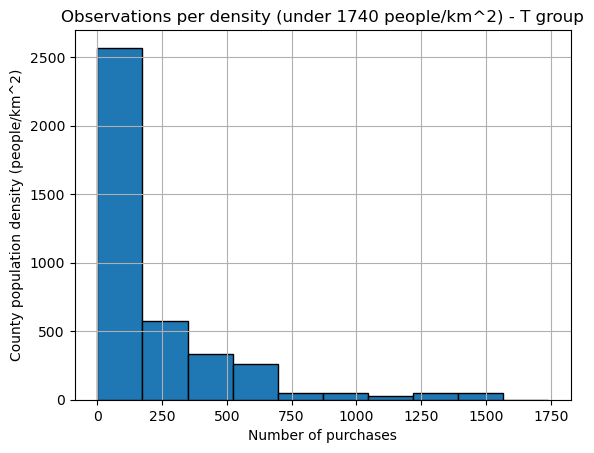

In [88]:
plt.hist(treatment_d["Population density (people/km^2)"], edgecolor='black', range=[0, 1740])
plt.xlabel('Number of purchases')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under 1740 people/km^2) - T group')
plt.grid(True)
plt.savefig("../../results_summary/density_treat_hist_under_1740.png")

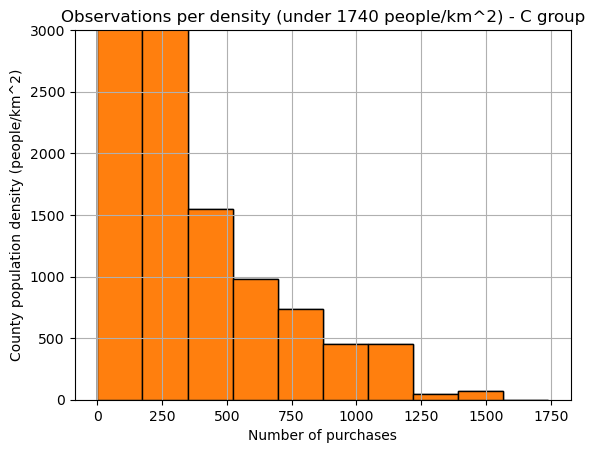

In [89]:
plt.hist(control_m["Population density (people/km^2)"], edgecolor='black', range=[0, 1740])
plt.hist(control_m["Population density (people/km^2)"], edgecolor='black', range=[0, 1740])
plt.xlabel('Number of purchases')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under 1740 people/km^2) - C group')
plt.ylim(0, 3000)
plt.grid(True)
plt.savefig("../../results_summary/density_control_hist_under 1740.png")

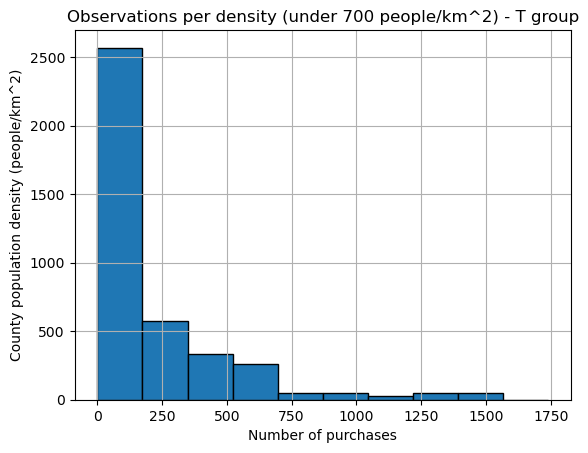

In [90]:
plt.hist(treatment_d["Population density (people/km^2)"], edgecolor='black', range=[0, 1740])
plt.xlabel('Number of purchases')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under 700 people/km^2) - T group')
plt.grid(True)
plt.savefig("../../results_summary/density_treat_hist_under_700.png")

In [ ]:
treatment_ld = treatment_d[treatment_d.B01001_calc_PopDensity<=1740]
treatment_hd = treatment_d[(treatment_d.B01001_calc_PopDensity<=4350)&(treatment_d.B01001_calc_PopDensity>=3915)]
control_m_ld = control_m[control_m.B01001_calc_PopDensity<=1740]
control_m_hd = control_m[(control_m.B01001_calc_PopDensity<=4350)&(control_m.B01001_calc_PopDensity>=3915)]